# Laboratorio 3
### Data science - Lynette Garcia
- Daniel Gomez 21429
- Abner Garcia 21285

In [18]:
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split

### Laboratorio anterior

In [19]:
# Cargar los datos
consuming = pd.read_csv('data/gas_consuming.csv', parse_dates=['Fecha'], index_col='Fecha', date_format='%b/%Y')
importation = pd.read_csv('data/gas_importation.csv', parse_dates=['Fecha'], index_col='Fecha', date_format='%b/%Y')

# Generar la columna 'Diesel' combinando 'Diesel bajo azufre' y 'Diesel ultra bajo azufre'
consuming['Diesel'] = consuming['Diesel bajo azufre'].fillna(0) + consuming['Diesel ultra bajo azufre'].fillna(0)
importation['Diesel'] = importation['Diesel bajo azufre'].fillna(0) + importation['Diesel ultra bajo azufre'].fillna(0)

# Primero, eliminamos cualquier carácter no numérico o espacios en blanco
consuming['Gasolina regular'] = consuming['Gasolina regular'].str.replace(',', '').str.strip()
consuming['Gasolina superior'] = consuming['Gasolina superior'].str.replace(',', '').str.strip()
consuming['Diesel'] = consuming['Diesel'].str.replace(',', '').str.strip()
consuming['Gas licuado de petróleo'] = consuming['Gas licuado de petróleo'].str.replace(',', '').str.strip()

importation['Gasolina regular'] = importation['Gasolina regular'].str.replace(',', '').str.strip()
importation['Gasolina superior'] = importation['Gasolina superior'].str.replace(',', '').str.strip()
importation['Diesel'] = importation['Diesel'].str.replace(',', '').str.strip()
importation['Gas licuado de petróleo'] = importation['Gas licuado de petróleo'].str.replace(',', '').str.strip()

# Luego, convertimos las columnas a float
consuming['Gasolina regular'] = pd.to_numeric(consuming['Gasolina regular'], errors='coerce')
consuming['Gasolina superior'] = pd.to_numeric(consuming['Gasolina superior'], errors='coerce')
consuming['Diesel'] = pd.to_numeric(consuming['Diesel'], errors='coerce')
consuming['Gas licuado de petróleo'] = pd.to_numeric(consuming['Gas licuado de petróleo'], errors='coerce')

importation['Gasolina regular'] = pd.to_numeric(importation['Gasolina regular'], errors='coerce')
importation['Gasolina superior'] = pd.to_numeric(importation['Gasolina superior'], errors='coerce')
importation['Diesel'] = pd.to_numeric(importation['Diesel'], errors='coerce')
importation['Gas licuado de petróleo'] = pd.to_numeric(importation['Gas licuado de petróleo'], errors='coerce')

# Obtener solo las columnas necesarias
gas = consuming[['Gasolina regular', 'Gasolina superior', 'Diesel', 'Gas licuado de petróleo']]
gas_importation = importation[['Gasolina regular', 'Gasolina superior', 'Diesel', 'Gas licuado de petróleo']]

# Verificamos la conversión
gas.info()
gas_importation.info()


<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, ene/2000 to may/2024
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gasolina regular         293 non-null    float64
 1   Gasolina superior        293 non-null    float64
 2   Diesel                   216 non-null    float64
 3   Gas licuado de petróleo  293 non-null    float64
dtypes: float64(4)
memory usage: 11.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 281 entries, ene/2001 to may/2024
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gasolina regular         281 non-null    float64
 1   Gasolina superior        280 non-null    float64
 2   Diesel                   213 non-null    float64
 3   Gas licuado de petróleo  280 non-null    float64
dtypes: float64(4)
memory usage: 11.0+ KB


In [20]:
gas.head()

,Gasolina regular,Gasolina superior,Diesel,Gas licuado de petróleo
Fecha,,,,
ene/2000,202.64520,308.15682,0.0,194.41048
feb/2000,205.53096,307.76631,0.0,174.71055
mar/2000,229.49956,331.91029,0.0,189.23407
abr/2000,210.68040,315.64808,0.0,174.33061
may/2000,208.16434,319.66797,0.0,191.74515


In [21]:
gas.describe()

,Gasolina regular,Gasolina superior,Diesel,Gas licuado de petróleo
count,293.000000,293.000000,216.0,293.000000
mean,386.490157,464.562247,0.0,312.350791
std,209.541305,108.349196,0.0,109.315235
min,160.741900,300.242780,0.0,167.818140
25%,214.509650,382.078880,0.0,225.886430
50%,285.089040,420.238710,0.0,262.255140
75%,524.242310,565.665720,0.0,393.901920
max,894.533140,768.102830,0.0,588.892160


In [22]:
#analysis = ProfileReport(gas)
#analysis.to_file('gas_consuming_analysis.html')
#analysis = ProfileReport(gas_importation)
#analysis.to_file('gas_importation_analysis.html')

In [23]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, ene/2000 to may/2024
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gasolina regular         293 non-null    float64
 1   Gasolina superior        293 non-null    float64
 2   Diesel                   216 non-null    float64
 3   Gas licuado de petróleo  293 non-null    float64
dtypes: float64(4)
memory usage: 11.4+ KB


### Serie de tiempo 1 lab anterior 


Consumo Mensual:
            Gasolina regular  Gasolina superior  Diesel  \
Fecha                                                     
2000-01-01         202.64520          308.15682     0.0   
2000-02-01         205.53096          307.76631     0.0   
2000-03-01         229.49956          331.91029     0.0   
2000-04-01         210.68040          315.64808     0.0   
2000-05-01         208.16434          319.66797     0.0   

            Gas licuado de petróleo  
Fecha                                
2000-01-01                194.41048  
2000-02-01                174.71055  
2000-03-01                189.23407  
2000-04-01                174.33061  
2000-05-01                191.74515  


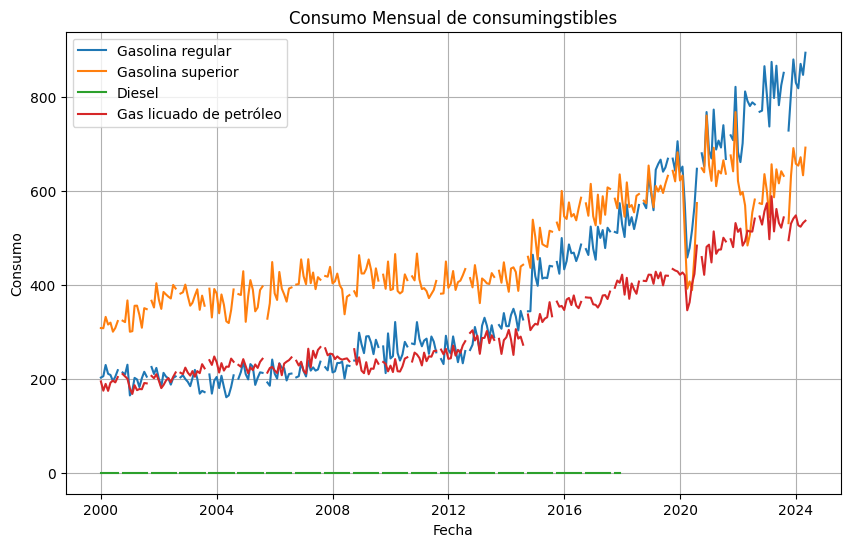

In [24]:
# Supongamos que 'consuming' es tu DataFrame y 'gas' es la lista de columnas de interés
gas = ['Gasolina regular', 'Gasolina superior', 'Diesel', 'Gas licuado de petróleo']

# Asegurarse de que las columnas sean de tipo 'object' (cadena de texto)
for column in gas:
    consuming[column] = consuming[column].astype(str)

# Eliminar cualquier carácter no numérico o espacios en blanco
for column in gas:
    consuming[column] = consuming[column].str.replace(',', '').str.strip()

# Convertir las columnas a float
for column in gas:
    consuming[column] = pd.to_numeric(consuming[column], errors='coerce')

# Diccionario para traducir los meses en español a inglés
meses_espanol = {
    'ene': 'Jan', 'feb': 'Feb', 'mar': 'Mar', 'abr': 'Apr', 'may': 'May', 'jun': 'Jun',
    'jul': 'Jul', 'ago': 'Aug', 'sep': 'Sep', 'sept': 'Sep', 'oct': 'Oct', 'nov': 'Nov', 'dic': 'Dec'
}

# Función para traducir las fechas
def traducir_fecha(fecha):
    if isinstance(fecha, str):
        for mes_es, mes_en in meses_espanol.items():
            fecha = fecha.replace(mes_es, mes_en)
    return fecha

# Asegurarse de que el índice sea de tipo 'object' (cadena de texto)
consuming.index = consuming.index.astype(str)

# Traducir las fechas en el índice
consuming.index = consuming.index.map(traducir_fecha)

# Asegurarse de que el índice sea de tipo datetime con el formato correcto
if not pd.api.types.is_datetime64_any_dtype(consuming.index):
    consuming.index = pd.to_datetime(consuming.index, format='%b/%Y', errors='coerce')

# Filtrar las series de interés
consumo = consuming[gas]

print('\nConsumo Mensual:')
print(consumo.head())

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
for column in gas:
    plt.plot(consumo.index, consumo[column], label=column)

plt.title('Consumo Mensual de consumingstibles')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

### Serie de tiempo 2 lab anterior


Consumo Mensual:
            Gasolina regular  Gasolina superior  Diesel  \
Fecha                                                     
2001-01-01         177.77650          373.96396     0.0   
2001-02-01         123.11599          243.09107     0.0   
2001-03-01         161.72642          312.08438     0.0   
2001-04-01         127.33874          285.05489     0.0   
2001-05-01         168.73019          300.91367     0.0   

            Gas licuado de petróleo  
Fecha                                
2001-01-01                194.06574  
2001-02-01                170.70338  
2001-03-01                161.83737  
2001-04-01                163.04864  
2001-05-01                171.51886  


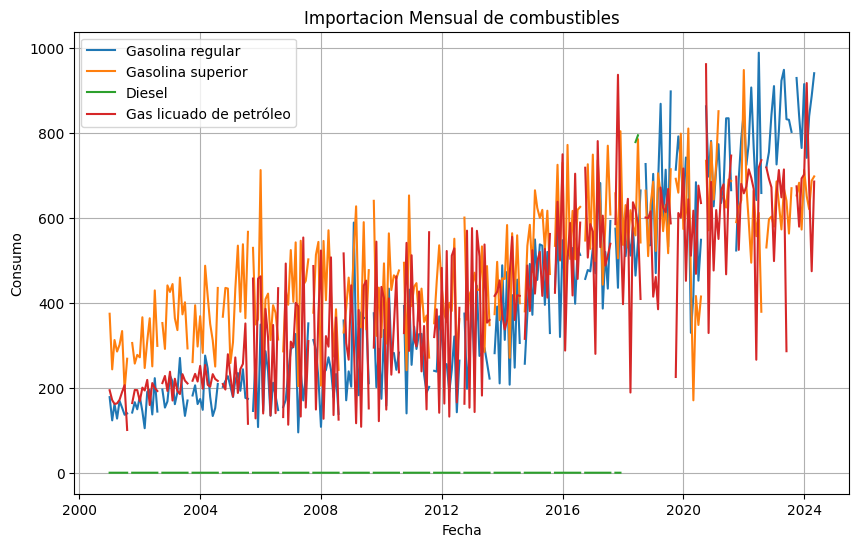

In [25]:
# Supongamos que 'importation' es tu DataFrame y 'gas' es la lista de columnas de interés
gas = ['Gasolina regular', 'Gasolina superior', 'Diesel', 'Gas licuado de petróleo']

# Asegurarse de que las columnas sean de tipo 'object' (cadena de texto)
for column in gas:
    importation[column] = importation[column].astype(str)

# Eliminar cualquier carácter no numérico o espacios en blanco
for column in gas:
    importation[column] = importation[column].str.replace(',', '').str.strip()

# Convertir las columnas a float
for column in gas:
    importation[column] = pd.to_numeric(importation[column], errors='coerce')

# Diccionario para traducir los meses en español a inglés
meses_espanol = {
    'ene': 'Jan', 'feb': 'Feb', 'mar': 'Mar', 'abr': 'Apr', 'may': 'May', 'jun': 'Jun',
    'jul': 'Jul', 'ago': 'Aug', 'sep': 'Sep', 'sept': 'Sep', 'oct': 'Oct', 'nov': 'Nov', 'dic': 'Dec'
}

# Función para traducir las fechas
def traducir_fecha(fecha):
    if isinstance(fecha, str):
        for mes_es, mes_en in meses_espanol.items():
            fecha = fecha.replace(mes_es, mes_en)
    return fecha

# Asegurarse de que el índice sea de tipo 'object' (cadena de texto)
importation.index = importation.index.astype(str)

# Traducir las fechas en el índice
importation.index = importation.index.map(traducir_fecha)

# Asegurarse de que el índice sea de tipo datetime con el formato correcto
if not pd.api.types.is_datetime64_any_dtype(importation.index):
    importation.index = pd.to_datetime(importation.index, format='%b/%Y', errors='coerce')

# Filtrar las series de interés
importacion = importation[gas]

print('\nConsumo Mensual:')
print(importacion.head())

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
for column in gas:
    plt.plot(importacion.index, importacion[column], label=column)

plt.title('Importacion Mensual de combustibles')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

### Serie de tiempo 3 lab anterior

In [26]:
# function for clean data and append the type of gas & service

def clean_data(data, service, gas_type):
    # delete unnamed columns
    for column in data.columns:
        if 'Unnamed' in column:
            del data[column]

    # concat the service column
    data['service'] = service
    # concat gas type
    data['type'] = gas_type

    return data

# super gas prices for complete service
super_complete_service_prices = pd.read_csv('data/super_complete_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
super_complete_service_prices = clean_data(super_complete_service_prices, 'Complete service', 'Super')

# super additive gas for self service
super_additive_complete_service_prices = pd.read_csv('data/super_additive_complete_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
super_additive_complete_service_prices = clean_data(super_additive_complete_service_prices, 'Complete service', 'Super additive')

# regular gas for complete service
regular_complete_service_prices = pd.read_csv('data/regular_complete_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
regular_complete_service_prices = clean_data(regular_complete_service_prices, 'Complete service', 'Regular')

# diesel gas for complete service
diesel_complete_service_prices = pd.read_csv('data/diesel_complete_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
diesel_complete_service_prices = clean_data(diesel_complete_service_prices, 'Complete service', 'Diesel')

# super gas for self service
super_self_service_prices = pd.read_csv('data/super_self_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
super_self_service_prices = clean_data(super_self_service_prices, 'Self service', 'Super')

# super additive gas for self service
super_additive_self_service_prices = pd.read_csv('data/super_additive_self_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
super_additive_self_service_prices = clean_data(super_additive_self_service_prices, 'Self service', 'Super additive')

# regular gas for self service
regular_self_service_prices = pd.read_csv('data/regular_self_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
regular_self_service_prices = clean_data(regular_self_service_prices, 'Self service', 'Regular')

# diesel gas for self service
diesel_self_service_prices = pd.read_csv('data/diesel_self_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
diesel_self_service_prices = clean_data(diesel_self_service_prices, 'Self service', 'Diesel')

# concat all data
gas_prices = pd.concat([
    super_complete_service_prices,
    super_additive_complete_service_prices,
    regular_complete_service_prices,
    diesel_complete_service_prices,
    super_self_service_prices,
    super_additive_self_service_prices,
    regular_self_service_prices,
    diesel_self_service_prices
])

# Reset index to get MES/AÑO as a column
gas_prices.reset_index(inplace=True)

# Convert the data to long format
gas_prices = pd.melt(
    gas_prices,
    id_vars=['MES/AÑO', 'service', 'type'], 
    var_name='Year',
    value_name='Price'
)

# Convert 'Price' to numeric (replace commas and convert to float)
gas_prices['Price'] = gas_prices['Price'].str.replace(',', '.').astype(float)

gas_prices.head()


,MES/AÑO,service,type,Year,Price
0,ENERO,Complete service,Super,2002,12.94
1,FEBRERO,Complete service,Super,2002,12.76
2,MARZO,Complete service,Super,2002,13.04
3,ABRIL,Complete service,Super,2002,14.60
4,MAYO,Complete service,Super,2002,14.65


In [27]:
#analysis = ProfileReport(long_df)
#analysis.to_file('gas_prices_analysis.html')

In [28]:
gas_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MES/AÑO  2392 non-null   object 
 1   service  2392 non-null   object 
 2   type     2392 non-null   object 
 3   Year     2392 non-null   object 
 4   Price    2332 non-null   float64
dtypes: float64(1), object(4)
memory usage: 93.6+ KB


In [29]:
gas_prices.describe()

,Price
count,2332.000000
mean,25.645214
std,6.832020
min,8.660000
25%,20.940000
50%,25.390000
75%,31.400000
max,42.680000


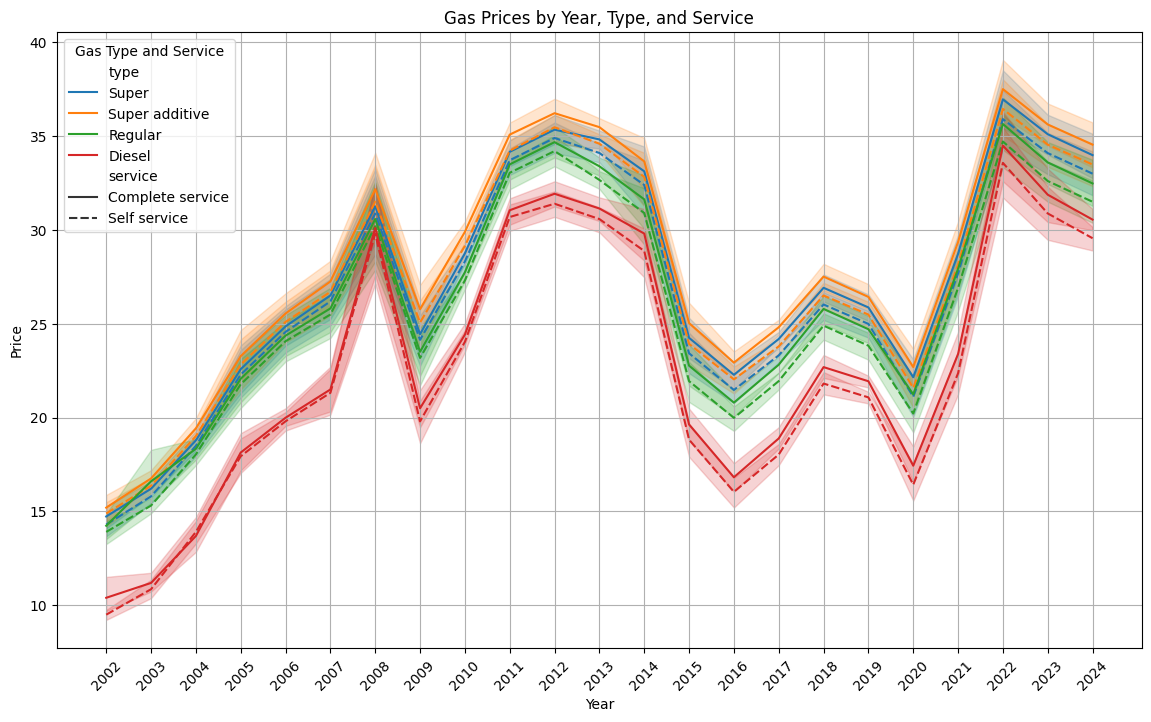

In [30]:
# Plot the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=gas_prices, x='Year', y='Price', hue='type', style='service')

plt.title('Gas Prices by Year, Type, and Service')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend(title='Gas Type and Service')
plt.grid(True)

plt.show()

1. Utilice los conjuntos de entrenamiento y prueba de una de las series que utilizó en el Laboratorio

In [31]:
# Utilizaremos la serie de ejemplo 1 'consumo' para obtener los datos de entrenamiento y prueba
# consumo' está correctamente cargado en el DataFrame

# Seleccionar las columnas de interés
data = consumo[['Gasolina regular', 'Gasolina superior', 'Diesel', 'Gas licuado de petróleo']]

# Dividir en conjuntos de entrenamiento y prueba como el laboratorio anterior
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Sustituir valores NaN en la columna 'Diesel' por 0 en el conjunto de prueba
test_data['Diesel'] = test_data['Diesel'].fillna(0)

print("Datos de entrenamiento:")
print(train_data.head())
print("\nDatos de prueba:")
print(test_data.head())

Datos de entrenamiento:
            Gasolina regular  Gasolina superior  Diesel  \
Fecha                                                     
2000-01-01         202.64520          308.15682     0.0   
2000-02-01         205.53096          307.76631     0.0   
2000-03-01         229.49956          331.91029     0.0   
2000-04-01         210.68040          315.64808     0.0   
2000-05-01         208.16434          319.66797     0.0   

            Gas licuado de petróleo  
Fecha                                
2000-01-01                194.41048  
2000-02-01                174.71055  
2000-03-01                189.23407  
2000-04-01                174.33061  
2000-05-01                191.74515  

Datos de prueba:
            Gasolina regular  Gasolina superior  Diesel  \
Fecha                                                     
2019-07-01         650.15078          615.55933     0.0   
2019-08-01         668.78339          632.41570     0.0   
NaT                616.07930          587.

2. Haga al menos 2 modelos con configuraciones diferentes usando LSTM por cada serie de las que utilizó. Haga un tuneo de parámetros de los modelos.

### Serie 1 consumos


Columna: Gasolina regular
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0897 - val_loss: 0.1876
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0163 - val_loss: 0.0103
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0931
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - val_loss: 0.0211
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_loss: 0.0368
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - val_loss: 0.0112
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - val_loss: 0.0116
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_loss: 0.0140
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - val_loss: 0.0117
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - val_loss: 0.0107
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 0.0111
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - val_loss: 0.0108
Epoch 13/20
7/7 ━━━━━━━

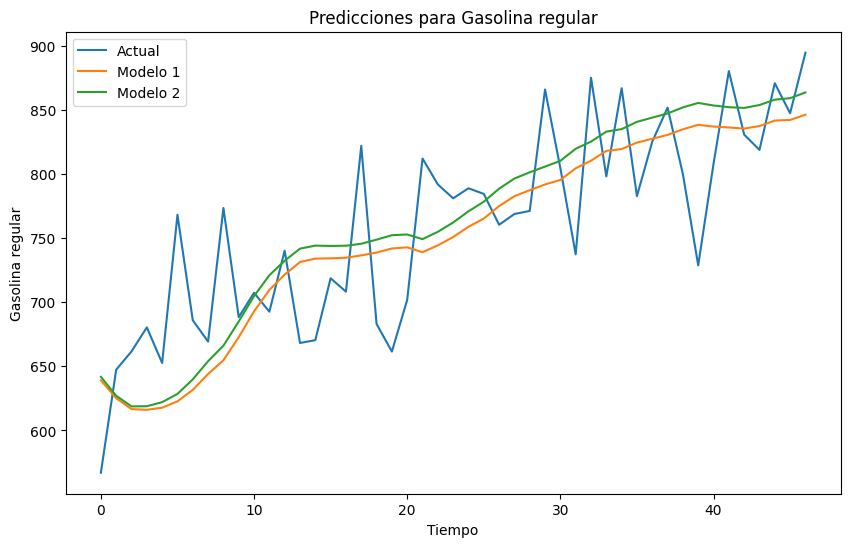


Columna: Gasolina superior
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1687 - val_loss: 0.1696
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0233 - val_loss: 0.0593
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225 - val_loss: 0.0648
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118 - val_loss: 0.0757
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 - val_loss: 0.0437
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0430
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0465
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 0.0442
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0453
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0447
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0446
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - val_loss: 0.0450
Epoch 13/20
7/7 ━━━━━━━

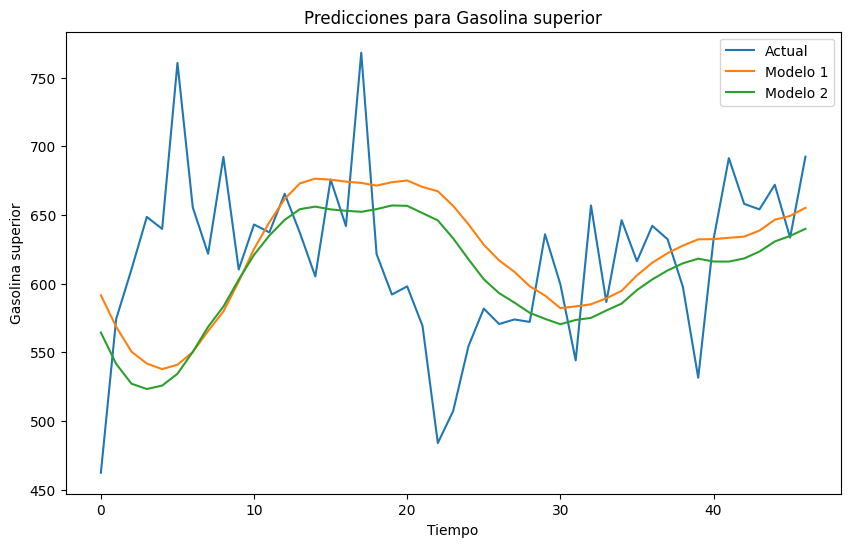


Columna: Diesel
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: nan - val_loss: nan
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan - val_loss: nan
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan - val_loss: nan
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan - val_loss: nan
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: nan - val_loss: nan
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan - val_loss: nan
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan - val_loss: nan
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan - val_loss: nan
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 14/20
7/7 ━

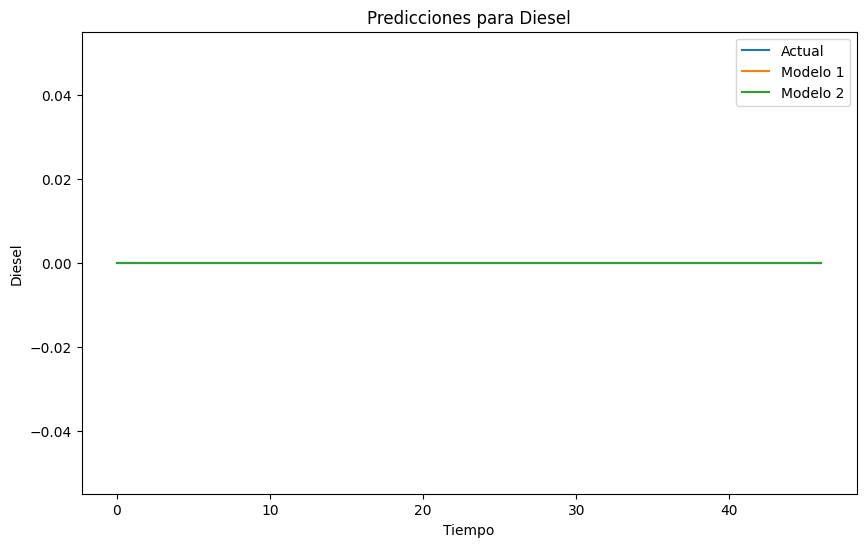


Columna: Gas licuado de petróleo
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1567 - val_loss: 0.3736
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0236 - val_loss: 0.0104
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - val_loss: 0.0667
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082 - val_loss: 0.0975
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087 - val_loss: 0.0103
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0102
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - val_loss: 0.0142
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - val_loss: 0.0105
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - val_loss: 0.0097
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - val_loss: 0.0096
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - val_loss: 0.0096
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - val_loss: 0.0102
Epoch 13/20
7/7 ━━━━━━━

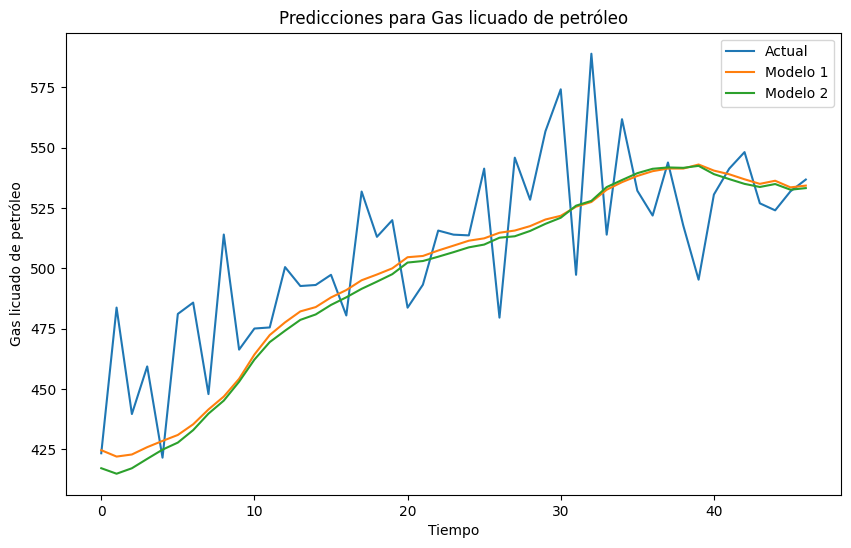

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

def prepare_data(train_data, test_data, seq_length):
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    X_train = create_sequences(train_data_scaled, seq_length)
    y_train = train_data_scaled[seq_length:]
    X_test = create_sequences(test_data_scaled, seq_length)
    y_test = test_data_scaled[seq_length:]

    return X_train, y_train, X_test, y_test, scaler

SEQ_LENGTH = 12

# Preparar los datos para cada columna
for column in data.columns:
    print(f"\nColumna: {column}")

    train_series = train_data[[column]]
    test_series = test_data[[column]]

    X_train, y_train, X_test, y_test, scaler = prepare_data(train_series, test_series, SEQ_LENGTH)

    # Modelo 1: Configuración básica
    model1 = Sequential([
        LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
        LSTM(50, return_sequences=False),
        Dense(1)
    ])
    model1.compile(optimizer='adam', loss='mse')
    model1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # Modelo 2: Configuración con Dropout y más unidades LSTM
    model2 = Sequential([
        LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model2.compile(optimizer='adam', loss='mse')
    model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # Evaluar y comparar los modelos
    predictions1 = model1.predict(X_test)
    predictions2 = model2.predict(X_test)

    # Desescalar las predicciones
    predictions1 = scaler.inverse_transform(predictions1)
    predictions2 = scaler.inverse_transform(predictions2)
    y_test_descaled = scaler.inverse_transform(y_test)

    # Asegurarse de que no haya NaN en las predicciones
    predictions1 = np.nan_to_num(predictions1)
    predictions2 = np.nan_to_num(predictions2)
    y_test_descaled = np.nan_to_num(y_test_descaled)

    mse1 = mean_squared_error(y_test_descaled, predictions1)
    mse2 = mean_squared_error(y_test_descaled, predictions2)

    print(f"MSE del Modelo 1 para {column}: {mse1}")
    print(f"MSE del Modelo 2 para {column}: {mse2}")

    # Graficar las predicciones
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_descaled, label='Actual')
    plt.plot(predictions1, label='Modelo 1')
    plt.plot(predictions2, label='Modelo 2')
    plt.title(f'Predicciones para {column}')
    plt.xlabel('Tiempo')
    plt.ylabel(column)
    plt.legend()
    plt.show()

### Serie 2 Importacion


Columna: Gasolina regular
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1107 - val_loss: 0.2832
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0268 - val_loss: 0.0134
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0267 - val_loss: 0.0498
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0148 - val_loss: 0.0562
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 - val_loss: 0.0179
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0166
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121 - val_loss: 0.0165
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0216
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107 - val_loss: 0.0312
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097 - val_loss: 0.0276
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - val_loss: 0.0242
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0114 - val_loss: 0.0202
Epoch 13/20
7/7 ━━━━━━━

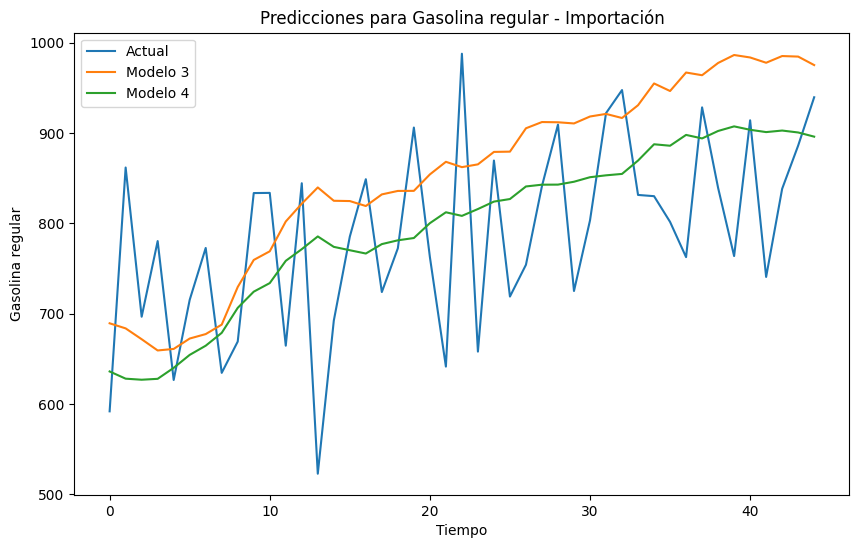


Columna: Gasolina superior
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1723 - val_loss: nan
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0316 - val_loss: nan
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0340 - val_loss: nan
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0304 - val_loss: nan
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0320 - val_loss: nan
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0301 - val_loss: nan
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0304 - val_loss: nan
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0271 - val_loss: nan
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0248 - val_loss: nan
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0271 - val_loss: nan
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0245 - val_loss: nan
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0290 - val_loss: nan
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

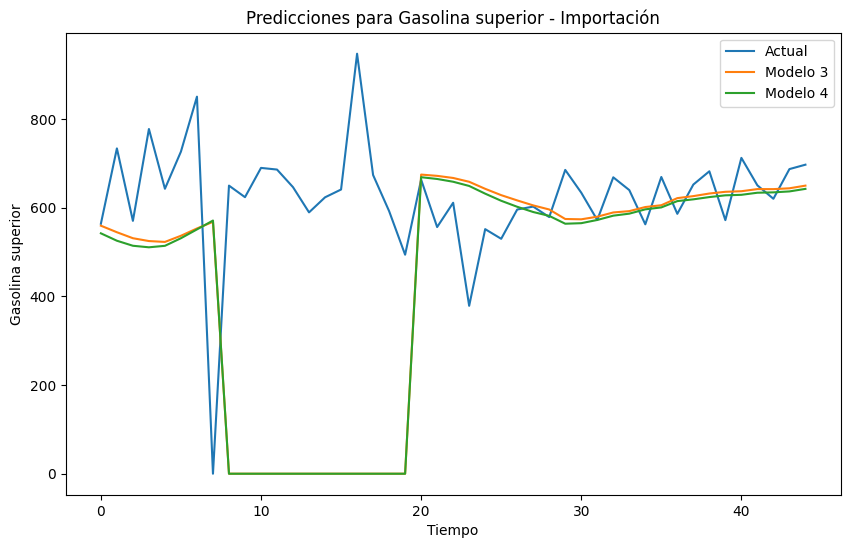


Columna: Diesel
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: nan - val_loss: nan
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan - val_loss: nan
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan - val_loss: nan
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan - val_loss: nan
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan - val_loss: nan
Epoch 14/20
7/7 ━━

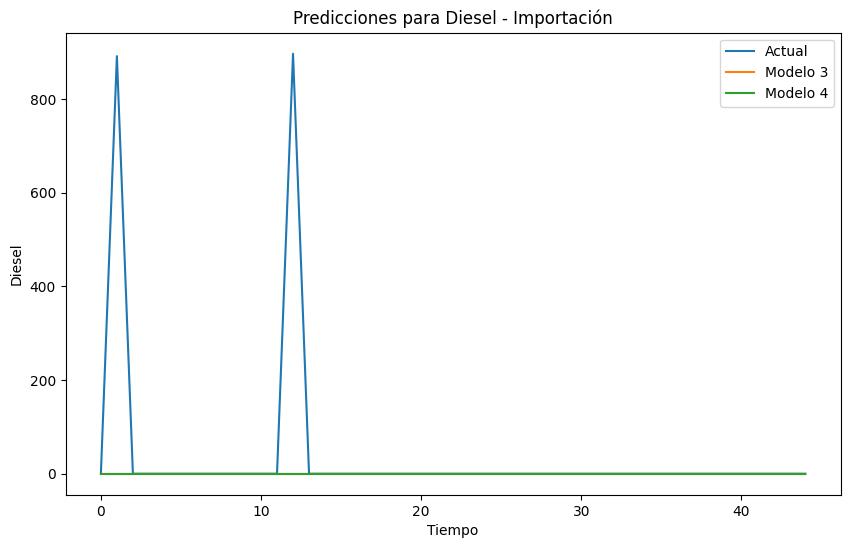


Columna: Gas licuado de petróleo
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1053 - val_loss: nan
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0282 - val_loss: nan
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0239 - val_loss: nan
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0274 - val_loss: nan
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0223 - val_loss: nan
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0228 - val_loss: nan
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0213 - val_loss: nan
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 - val_loss: nan
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0208 - val_loss: nan
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0218 - val_loss: nan
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 - val_loss: nan
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - val_loss: nan
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

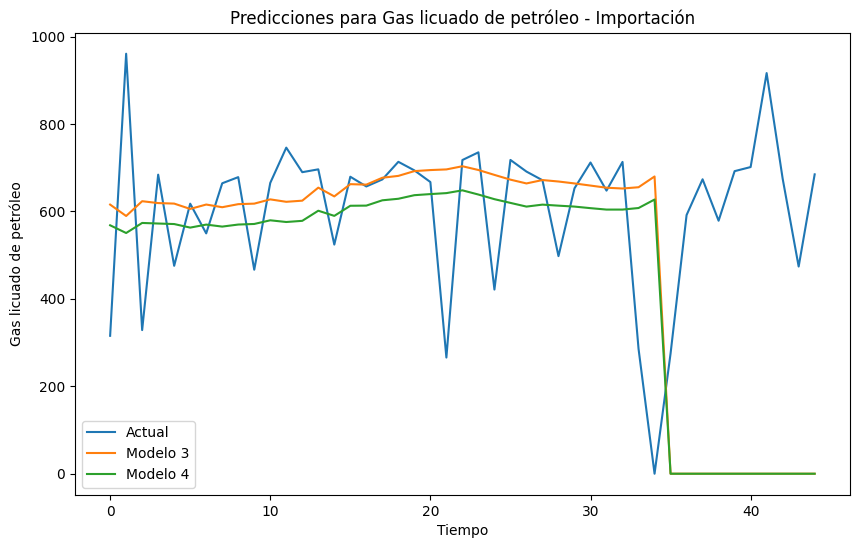

In [33]:
# Seleccionar las columnas de interés
data_importacion = importacion[['Gasolina regular', 'Gasolina superior', 'Diesel', 'Gas licuado de petróleo']]

# Dividir en conjuntos de entrenamiento y prueba
train_data_import, test_data_import = train_test_split(data_importacion, test_size=0.2, shuffle=False)

for column in data_importacion.columns:
    print(f"\nColumna: {column}")

    train_series_import = train_data_import[[column]]
    test_series_import = test_data_import[[column]]

    X_train_import, y_train_import, X_test_import, y_test_import, scaler_import = prepare_data(train_series_import, test_series_import, SEQ_LENGTH)

    # Modelo 3: Configuración básica
    model3 = Sequential([
        LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
        LSTM(50, return_sequences=False),
        Dense(1)
    ])
    model3.compile(optimizer='adam', loss='mse')
    model3.fit(X_train_import, y_train_import, epochs=20, batch_size=32, validation_data=(X_test_import, y_test_import))

    # Modelo 4: Configuración con Dropout y más unidades LSTM
    model4 = Sequential([
        LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model4.compile(optimizer='adam', loss='mse')
    model4.fit(X_train_import, y_train_import, epochs=20, batch_size=32, validation_data=(X_test_import, y_test_import))

    # Evaluar y comparar los modelos
    predictions3 = model3.predict(X_test_import)
    predictions4 = model4.predict(X_test_import)

    # Desescalar las predicciones
    predictions3 = scaler_import.inverse_transform(predictions3)
    predictions4 = scaler_import.inverse_transform(predictions4)
    y_test_import_descaled = scaler_import.inverse_transform(y_test_import)

    # Asegurarse de que no haya NaN en las predicciones
    predictions3 = np.nan_to_num(predictions3)
    predictions4 = np.nan_to_num(predictions4)
    y_test_import_descaled = np.nan_to_num(y_test_import_descaled)

    mse3 = mean_squared_error(y_test_import_descaled, predictions3)
    mse4 = mean_squared_error(y_test_import_descaled, predictions4)

    print(f"MSE del Modelo 3 para {column}: {mse3}")
    print(f"MSE del Modelo 4 para {column}: {mse4}")

    # Graficar las predicciones
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_import_descaled, label='Actual')
    plt.plot(predictions3, label='Modelo 3')
    plt.plot(predictions4, label='Modelo 4')
    plt.title(f'Predicciones para {column} - Importación')
    plt.xlabel('Tiempo')
    plt.ylabel(column)
    plt.legend()
    plt.show()

### Serie 3 Precios

In [60]:
# function for clean data and append the type of gas & service

def clean_data(data, service, gas_type):
    # delete unnamed columns
    for column in data.columns:
        if 'Unnamed' in column:
            del data[column]

    # concat the service column
    data['service'] = service
    # concat gas type
    data['type'] = gas_type

    return data

# super gas prices for complete service
super_complete_service_prices = pd.read_csv('data/super_complete_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
super_complete_service_prices = clean_data(super_complete_service_prices, 'Complete service', 'Super')

# super additive gas for self service
super_additive_complete_service_prices = pd.read_csv('data/super_additive_complete_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
super_additive_complete_service_prices = clean_data(super_additive_complete_service_prices, 'Complete service', 'Super additive')

# regular gas for complete service
regular_complete_service_prices = pd.read_csv('data/regular_complete_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
regular_complete_service_prices = clean_data(regular_complete_service_prices, 'Complete service', 'Regular')

# diesel gas for complete service
diesel_complete_service_prices = pd.read_csv('data/diesel_complete_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
diesel_complete_service_prices = clean_data(diesel_complete_service_prices, 'Complete service', 'Diesel')

# super gas for self service
super_self_service_prices = pd.read_csv('data/super_self_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
super_self_service_prices = clean_data(super_self_service_prices, 'Self service', 'Super')

# super additive gas for self service
super_additive_self_service_prices = pd.read_csv('data/super_additive_self_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
super_additive_self_service_prices = clean_data(super_additive_self_service_prices, 'Self service', 'Super additive')

# regular gas for self service
regular_self_service_prices = pd.read_csv('data/regular_self_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
regular_self_service_prices = clean_data(regular_self_service_prices, 'Self service', 'Regular')

# diesel gas for self service
diesel_self_service_prices = pd.read_csv('data/diesel_self_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
diesel_self_service_prices = clean_data(diesel_self_service_prices, 'Self service', 'Diesel')

# concat all data
gas_prices = pd.concat([
    super_complete_service_prices,
    super_additive_complete_service_prices,
    regular_complete_service_prices,
    diesel_complete_service_prices,
    super_self_service_prices,
    super_additive_self_service_prices,
    regular_self_service_prices,
    diesel_self_service_prices
])

# Reset index to get MES/AÑO as a column
gas_prices.reset_index(inplace=True)

# Convert the data to long format
gas_prices = pd.melt(
    gas_prices,
    id_vars=['MES/AÑO', 'service', 'type'], 
    var_name='Year',
    value_name='Price'
)

# Convert 'Price' to numeric (replace commas and convert to float)
gas_prices['Price'] = gas_prices['Price'].str.replace(',', '.').astype(float)

gas_prices.head()

,MES/AÑO,service,type,Year,Price
0,ENERO,Complete service,Super,2002,12.94
1,FEBRERO,Complete service,Super,2002,12.76
2,MARZO,Complete service,Super,2002,13.04
3,ABRIL,Complete service,Super,2002,14.60
4,MAYO,Complete service,Super,2002,14.65


In [61]:
# Utilizaremos la serie de ejemplo 1 'consumo' para obtener los datos de entrenamiento y prueba
# consumo' está correctamente cargado en el DataFrame

# Seleccionar las columnas de interés
# la columna viene en: 
"""
	MES/AÑO		service				type			Year	Price
0	ENERO		Complete service	Super			2002	12.94
1	FEBRERO		Self service		Super additive	2002	12.76
2	MARZO		Complete service	Regular			2002	13.04
3	ABRIL		Complete service	Diesel			2002	14.60
4	MAYO		Complete service	Super			2002	14.65
"""

# por lo que se debe hacer un pivot para tener las columnas de interés
gas_prices = gas_prices.pivot_table(index=['MES/AÑO', 'Year'], columns=['service', 'type'], values='Price').reset_index()

# Seleccionar las columnas de interés después de hacer el pivot
data = gas_prices[[
    ('Complete service', 'Super'),
    ('Complete service', 'Super additive'),
    ('Complete service', 'Regular'),
    ('Complete service', 'Diesel'),
    ('Self service', 'Super'),
    ('Self service', 'Super additive'),
    ('Self service', 'Regular'),
    ('Self service', 'Diesel'),
]]

# Dividir en conjuntos de entrenamiento y prueba como el laboratorio anterior
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

print("Datos de entrenamiento:")
print(train_data.head())
print("\nDatos de prueba:")
print(test_data.head())

Datos de entrenamiento:
service Complete service                               Self service  \
type               Super Super additive Regular Diesel        Super   
0                  14.60          15.18   14.22   9.74        14.11   
1                  17.01          17.42   16.50  12.63        16.49   
2                  18.48          19.16   18.07  12.54        18.29   
3                  21.94          22.70   21.42  18.01        21.70   
4                  24.48          25.36   23.99  19.63        24.15   

service                                
type    Super additive Regular Diesel  
0                14.76   13.71   9.38  
1                16.97   15.96  12.22  
2                18.83   17.87  13.71  
3                22.23   21.18  17.89  
4                24.86   23.65  19.35  

Datos de prueba:
service Complete service                               Self service  \
type               Super Super additive Regular Diesel        Super   
233                28.80          29.9


Columna: ('Complete service', 'Super')
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2254 - val_loss: 0.0820
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0662 - val_loss: 0.0677
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0666 - val_loss: 0.0585
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0514 - val_loss: 0.0622
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0554 - val_loss: 0.0541
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0542 - val_loss: 0.0535
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0555 - val_loss: 0.0539
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0510 - val_loss: 0.0544
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0486 - val_loss: 0.0534
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0505 - val_loss: 0.0522
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0546 - val_loss: 0.0535
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0536 - val_loss: 0.0525
Epoch 13/20
7/7 ━━━━━━━

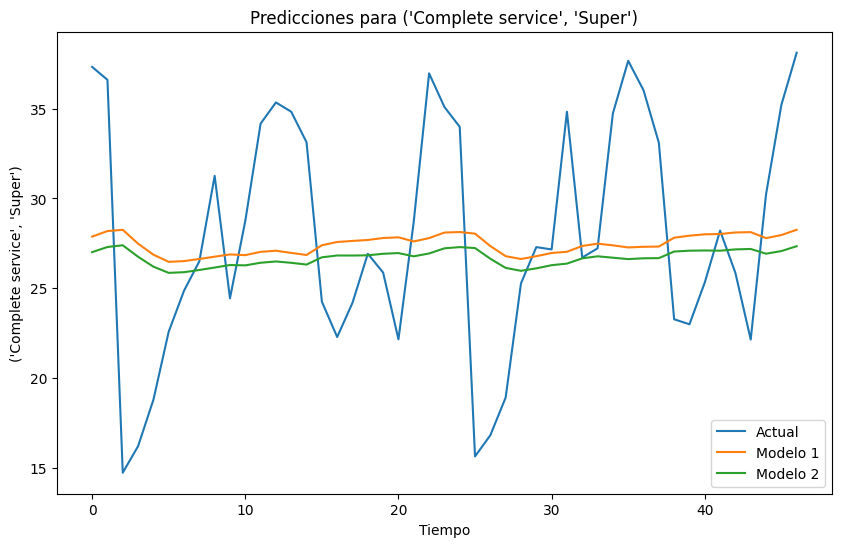


Columna: ('Complete service', 'Super additive')
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: nan - val_loss: nan
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan - val_loss: nan
Epoch 14/20
7/7 ━━

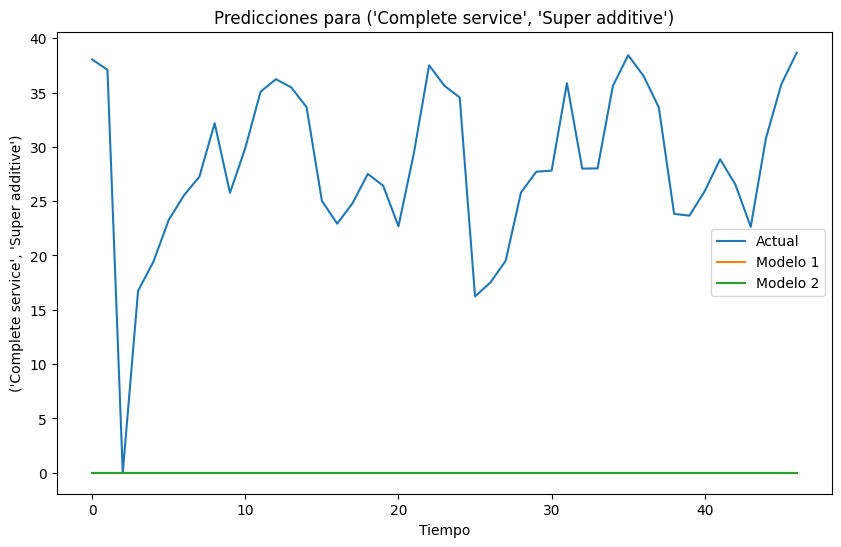


Columna: ('Complete service', 'Regular')
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: nan - val_loss: nan
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan - val_loss: nan
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 14/20
7/7 ━━

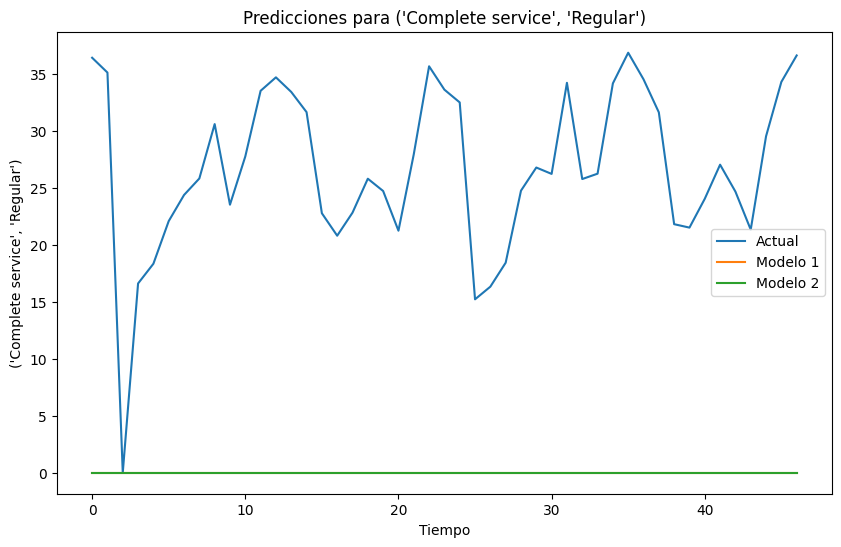


Columna: ('Complete service', 'Diesel')
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1689 - val_loss: 0.0656
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0752 - val_loss: 0.0644
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0597 - val_loss: 0.0787
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0694 - val_loss: 0.0664
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0576 - val_loss: 0.0638
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0651 - val_loss: 0.0630
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0583 - val_loss: 0.0638
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0567 - val_loss: 0.0652
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0650 - val_loss: 0.0622
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0541 - val_loss: 0.0614
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0500 - val_loss: 0.0619
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0560 - val_loss: 0.0623
Epoch 13/20
7/7 ━━━━━━━

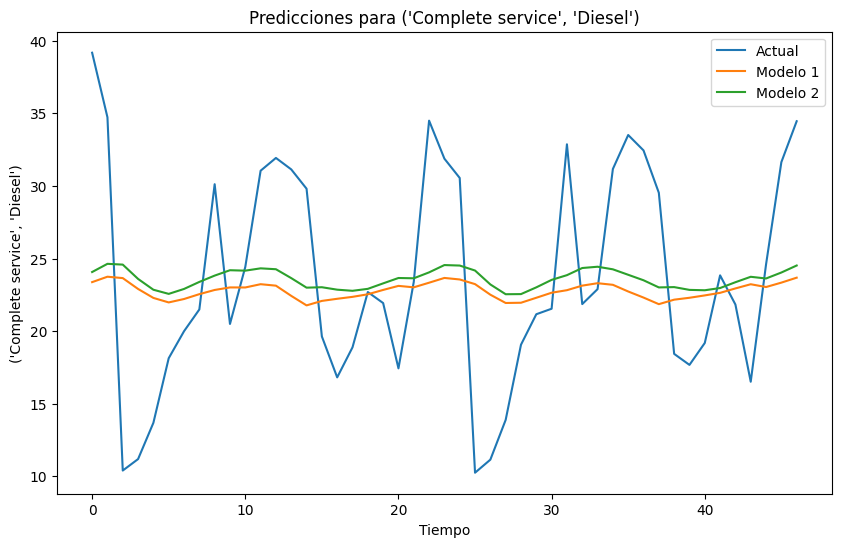


Columna: ('Self service', 'Super')
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1834 - val_loss: 0.0560
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0675 - val_loss: 0.0584
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0575 - val_loss: 0.0605
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0548 - val_loss: 0.0599
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0558 - val_loss: 0.0526
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0554 - val_loss: 0.0523
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0525 - val_loss: 0.0550
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0556 - val_loss: 0.0534
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0550 - val_loss: 0.0517
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0515 - val_loss: 0.0514
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0527 - val_loss: 0.0532
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0533 - val_loss: 0.0513
Epoch 13/20
7/7 ━━━━━━━

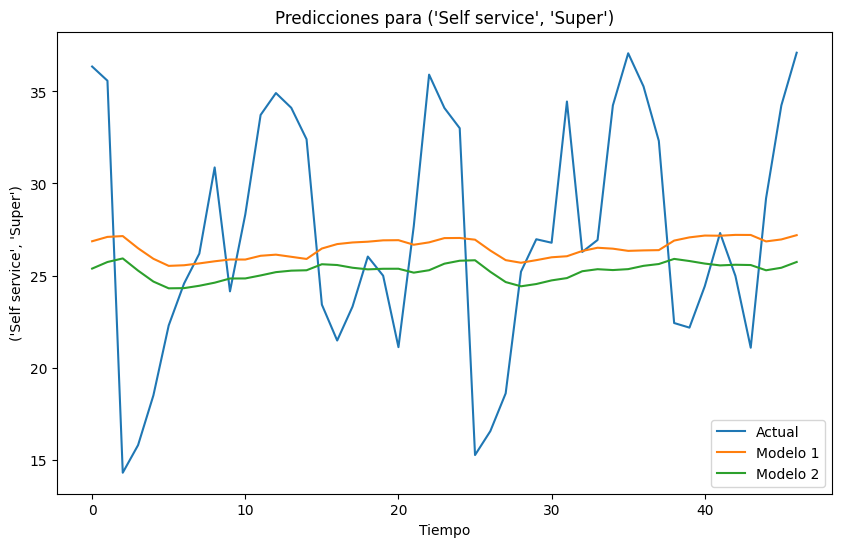


Columna: ('Self service', 'Super additive')
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1781 - val_loss: 0.0566
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0633 - val_loss: 0.0585
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0555 - val_loss: 0.0615
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0584 - val_loss: 0.0579
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0518 - val_loss: 0.0527
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0549 - val_loss: 0.0525
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0575 - val_loss: 0.0547
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0515 - val_loss: 0.0533
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0496 - val_loss: 0.0517
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0476 - val_loss: 0.0524
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0515 - val_loss: 0.0521
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0486 - val_loss: 0.0513
Epoch 13/20
7/7 ━━━━━━━

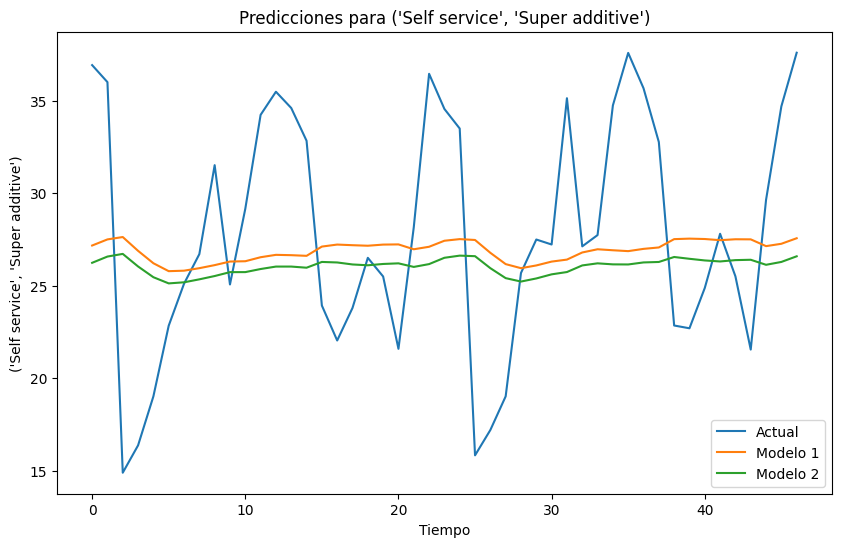


Columna: ('Self service', 'Regular')
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2426 - val_loss: 0.0946
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0685 - val_loss: 0.0758
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0690 - val_loss: 0.0610
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0583 - val_loss: 0.0690
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0618 - val_loss: 0.0563
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0583 - val_loss: 0.0558
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0587 - val_loss: 0.0564
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0573 - val_loss: 0.0586
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0539 - val_loss: 0.0556
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0535 - val_loss: 0.0552
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0541 - val_loss: 0.0547
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0552 - val_loss: 0.0557
Epoch 13/20
7/7 ━━━━━━━

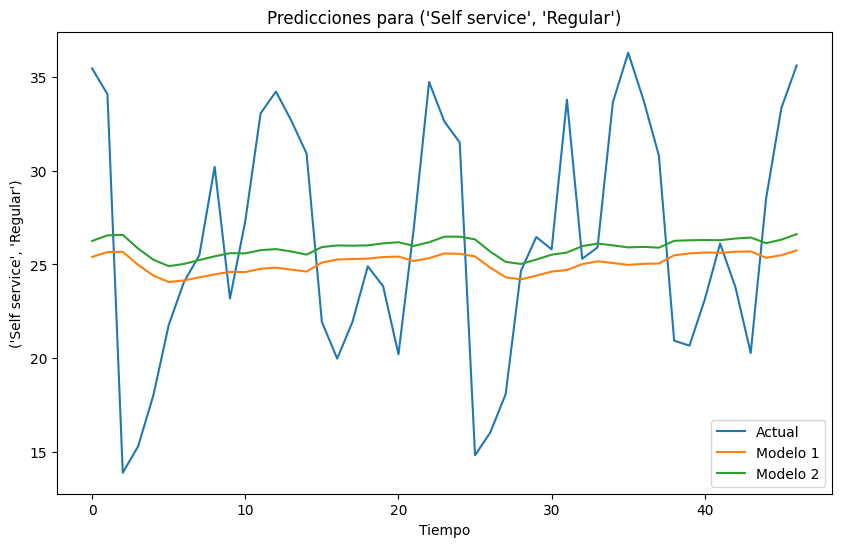


Columna: ('Self service', 'Diesel')
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2092 - val_loss: 0.0759
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0680 - val_loss: 0.0726
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0707 - val_loss: 0.0707
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0683 - val_loss: 0.0710
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0611 - val_loss: 0.0644
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0615 - val_loss: 0.0642
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0660 - val_loss: 0.0666
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0641 - val_loss: 0.0649
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0614 - val_loss: 0.0632
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0618 - val_loss: 0.0635
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0614 - val_loss: 0.0631
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0615 - val_loss: 0.0635
Epoch 13/20
7/7 ━━━━━━━

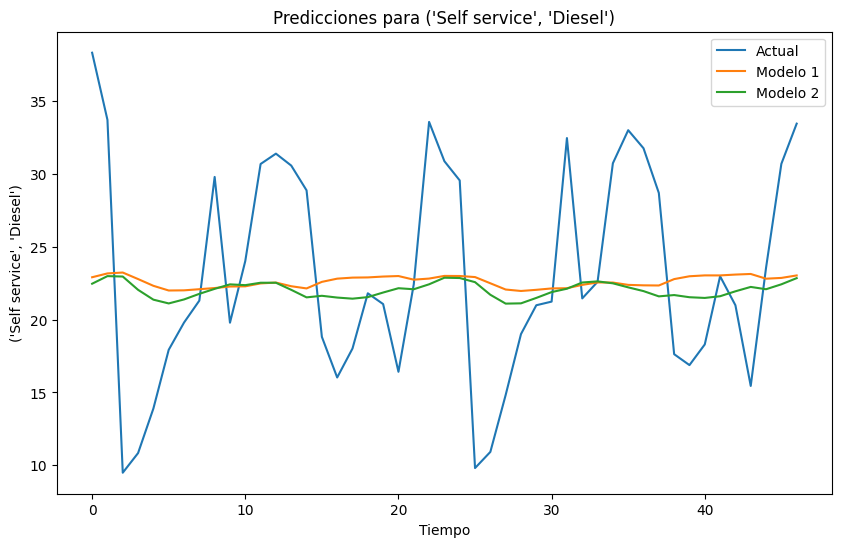

In [62]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

def prepare_data(train_data, test_data, seq_length):
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    X_train = create_sequences(train_data_scaled, seq_length)
    y_train = train_data_scaled[seq_length:]
    X_test = create_sequences(test_data_scaled, seq_length)
    y_test = test_data_scaled[seq_length:]

    return X_train, y_train, X_test, y_test, scaler

SEQ_LENGTH = 12

# Preparar los datos para cada columna
for column in data.columns:
    print(f"\nColumna: {column}")

    train_series = train_data[[column]]
    test_series = test_data[[column]]

    X_train, y_train, X_test, y_test, scaler = prepare_data(train_series, test_series, SEQ_LENGTH)

    # Modelo 1: Configuración básica
    model1 = Sequential([
        LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
        LSTM(50, return_sequences=False),
        Dense(1)
    ])
    model1.compile(optimizer='adam', loss='mse')
    model1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # Modelo 2: Configuración con Dropout y más unidades LSTM
    model2 = Sequential([
        LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model2.compile(optimizer='adam', loss='mse')
    model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # Evaluar y comparar los modelos
    predictions1 = model1.predict(X_test)
    predictions2 = model2.predict(X_test)

    # Desescalar las predicciones
    predictions1 = scaler.inverse_transform(predictions1)
    predictions2 = scaler.inverse_transform(predictions2)
    y_test_descaled = scaler.inverse_transform(y_test)

    # Asegurarse de que no haya NaN en las predicciones
    predictions1 = np.nan_to_num(predictions1)
    predictions2 = np.nan_to_num(predictions2)
    y_test_descaled = np.nan_to_num(y_test_descaled)

    mse1 = mean_squared_error(y_test_descaled, predictions1)
    mse2 = mean_squared_error(y_test_descaled, predictions2)

    print(f"MSE del Modelo 1 para {column}: {mse1}")
    print(f"MSE del Modelo 2 para {column}: {mse2}")

    # Graficar las predicciones
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_descaled, label='Actual')
    plt.plot(predictions1, label='Modelo 1')
    plt.plot(predictions2, label='Modelo 2')
    plt.title(f'Predicciones para {column}')
    plt.xlabel('Tiempo')
    plt.ylabel(column)
    plt.legend()
    plt.show()